# Tarea Semanal 5: Estimación espectral: Ancho de banda de señales reales

Se nos presentan 3 tipos de señales: 

-Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
-Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
-Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

Todas estas son muestras tomadas de su correspondiente dispositivo de medicion. El objetivo es estimar su ancho de banda de cada una de las señales presentadas.

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.



In [13]:
import numpy as np
from scipy import signal as sig
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as sio
from scipy.io.wavfile import write
import sounddevice as sd

from scipy import signal
from scipy.fft import fft, fftshift
import pandas as pd
rng = np.random.default_rng()

In [14]:
#Funciones

def blackman_tukey(x,  M = None):    
    
    # N = len(x)
    x_z = x.shape
    
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1

    # hay que aplanar los arrays por np.correlate.
    # usaremos el modo same que simplifica el tratamiento
    # de la autocorr
    xx = x.ravel()[:r_len];

    r = np.correlate(xx, xx, mode='same') / r_len

    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N) )

    Px = Px.reshape(x_z)

    return Px;
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)


# Metodo
Primero se carga el archivo npy con los datos del ecg, se hace una medicion del numero de muestras para poder obtener la resolucion espectral de la señal, ademas de que se normaliza en potencia. Luego se aplicaron los metodos de welch para la estimacion espectral 

# ECG

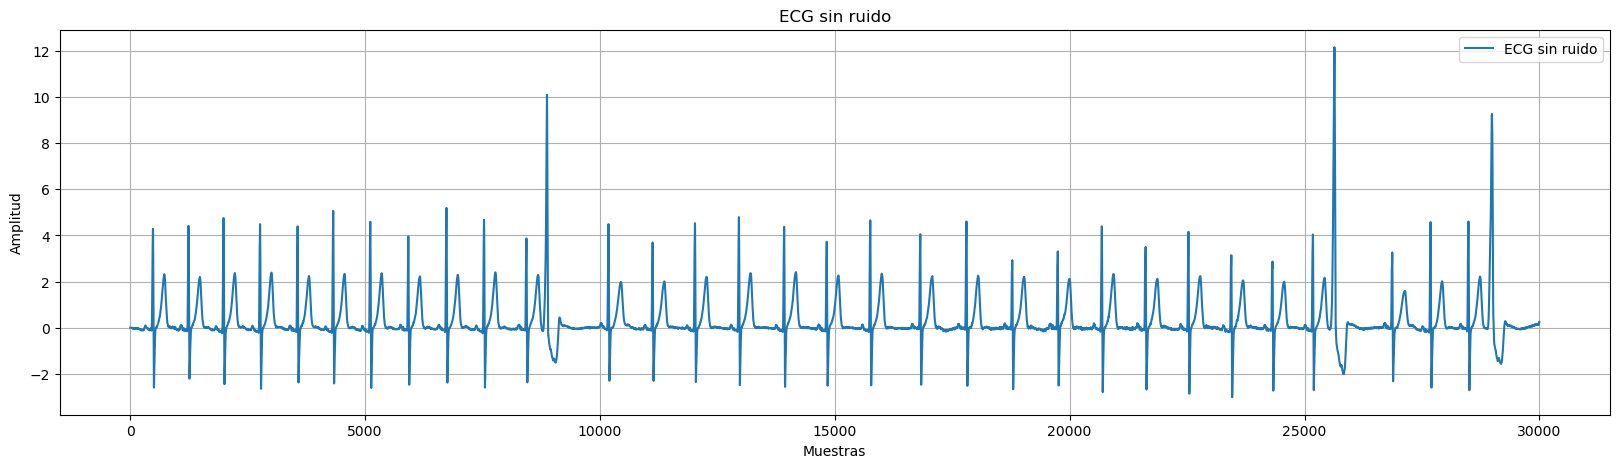

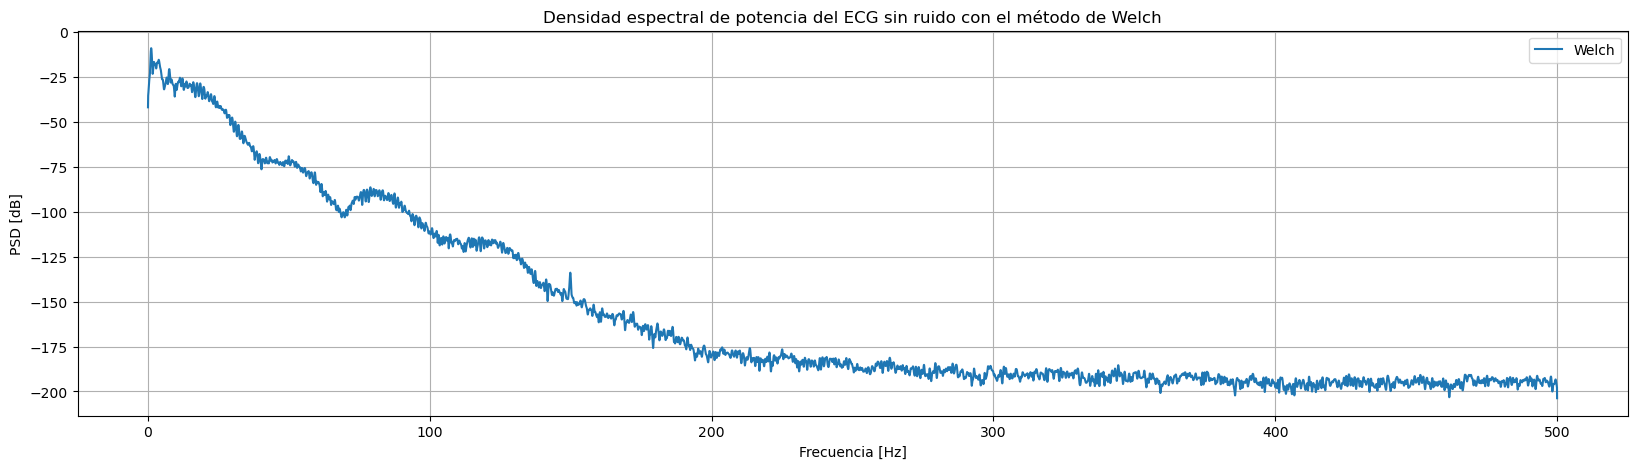

In [ ]:
fs_ecg = 1000 # Hz # Hz

# para listar las variables que hay en el archivo
ecg_sin_ruido = np.load('./ecg_sin_ruido.npy') # cargar el archivo . npy

N = len(ecg_sin_ruido) # Número de muestras
nor_ecg = ecg_sin_ruido / np.std(ecg_sin_ruido) # normalizamos el ECG

fw_ecg, Pxxw_ecg = signal.welch(nor_ecg, fs_ecg, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(1,figsize=(20, 5))
plt.plot(nor_ecg, label='ECG sin ruido')
plt.title('ECG sin ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_ecg,10*np.log10(2*np.abs(Pxxw_ecg)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()


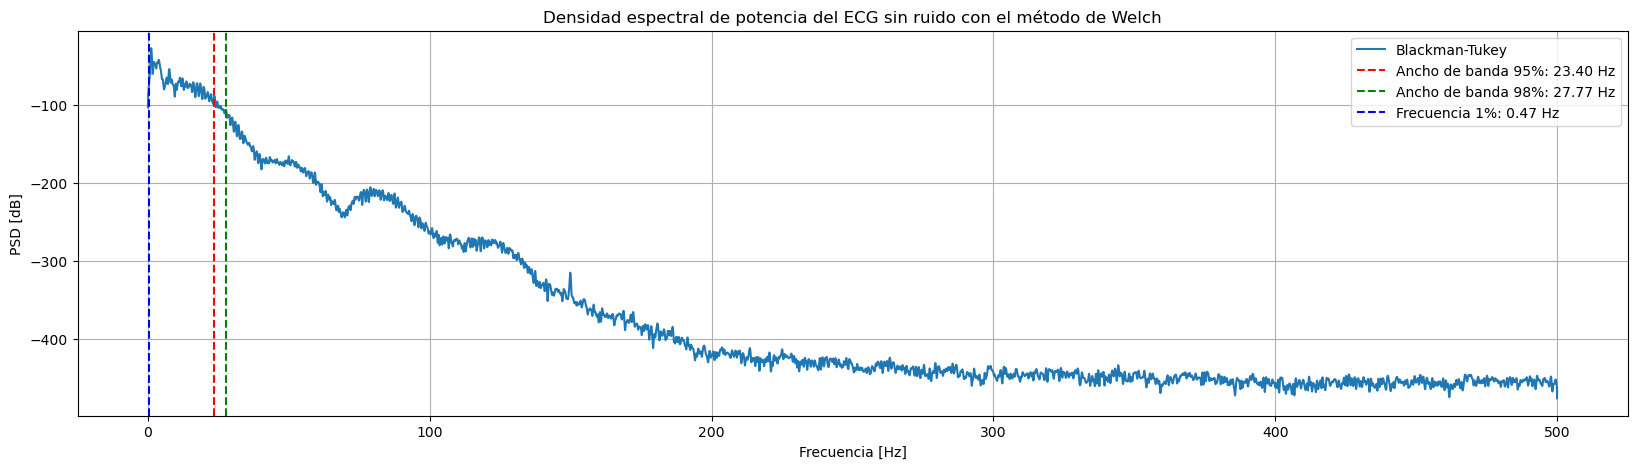

In [16]:
energia_total_w_ecg=np.sum(Pxxw_ecg) # La energia total del ECG espectro
energia_acumulada_w_ecg=np.cumsum(Pxxw_ecg) # La energia acumulada del ECG espectro
index_01_w_ecg=np.where(energia_acumulada_w_ecg>=0.01*energia_total_w_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_95_w_ecg=np.where(energia_acumulada_w_ecg>=0.95*energia_total_w_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_98_w_ecg=np.where(energia_acumulada_w_ecg>=0.98*energia_total_w_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
ancho_banda_95_ecg_w=fw_ecg[indx_95_w_ecg] # El ancho de banda del ECG espectro
ancho_banda_98_ecg_w=fw_ecg[indx_98_w_ecg] # El ancho de banda del ECG espectro

plt.figure(3,figsize=(20, 5))
plt.plot(fw_ecg,10*np.log(np.abs(Pxxw_ecg)**2), label='Blackman-Tukey')
plt.axvline(x=ancho_banda_95_ecg_w, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_w:.2f} Hz')
plt.axvline(x=ancho_banda_98_ecg_w, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_w:.2f} Hz')
plt.axvline(x=fw_ecg[index_01_w_ecg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ecg[index_01_w_ecg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

Para una mejor comprension de por que es correcto ancho de banda del ECg, decidi graficar la PSD sin pasar los valores a decibelios quedando de la siguiente manera:

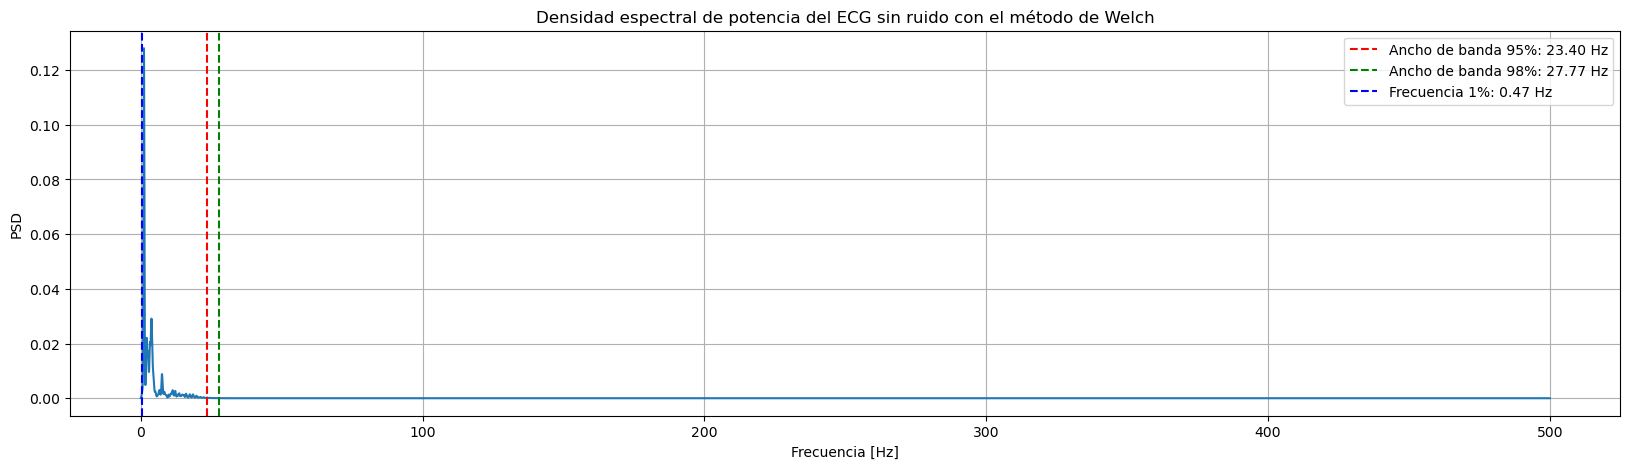

In [17]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_ecg,2*np.abs(Pxxw_ecg)**2)
plt.axvline(x=ancho_banda_95_ecg_w, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_w:.2f} Hz')
plt.axvline(x=ancho_banda_98_ecg_w, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_w:.2f} Hz')
plt.axvline(x=fw_ecg[index_01_w_ecg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ecg[index_01_w_ecg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

Como se puede notar toda la potencia esta concentrada dentro de los umbrales planteados previamente, llegando asi a un buen valor del ancho de banda obtenido mediante este metodo.
Lo mismo se repitio para todos las señales del trabajo. 

# ECG con Ruido

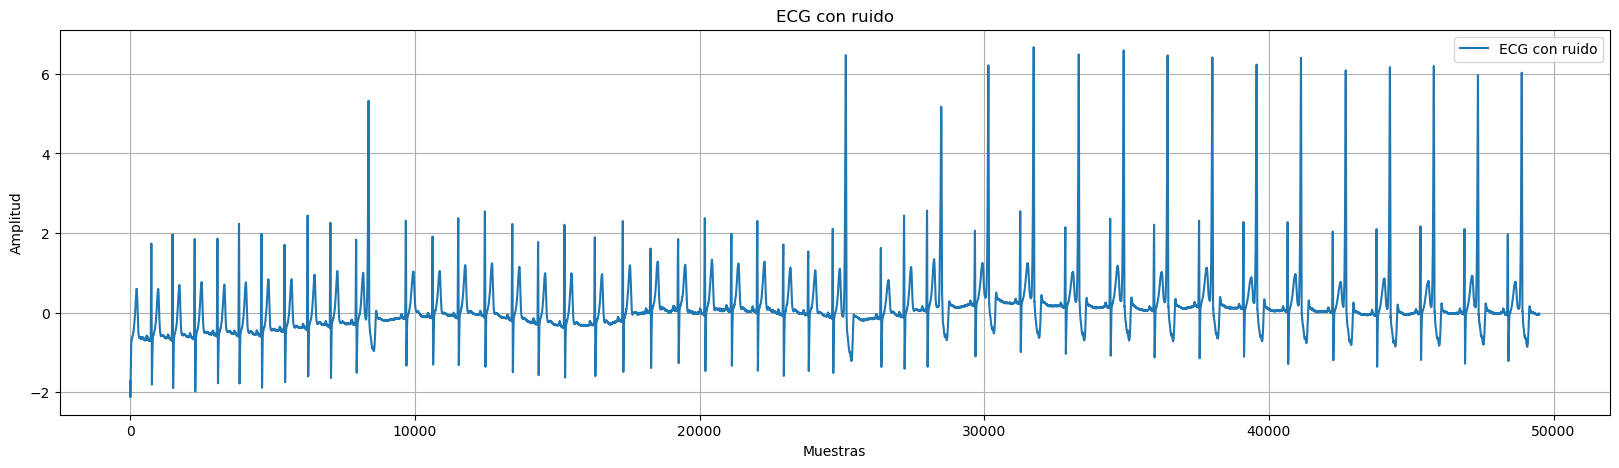

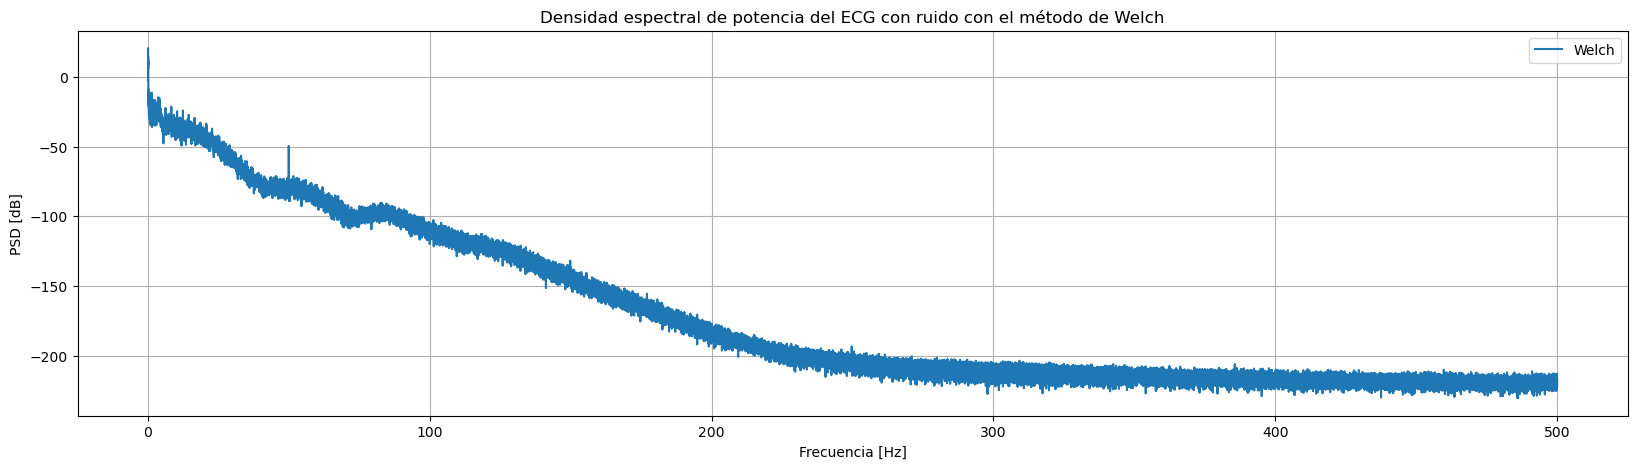

In [18]:
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N=len(ecg_one_lead)
ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead) # normalizamos el ECG
fs_ecg = 1000 # Hz 
fw_ecg_ruido, Pxxw_ecg_ruido = signal.welch(ecg_one_lead, fs_ecg, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(5,figsize=(20, 5))
plt.plot(ecg_one_lead[500:50000], label='ECG con ruido')
plt.title('ECG con ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

plt.figure(6,figsize=(20, 5))
plt.plot(fw_ecg_ruido,10*np.log10(2*np.abs(Pxxw_ecg_ruido)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG con ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

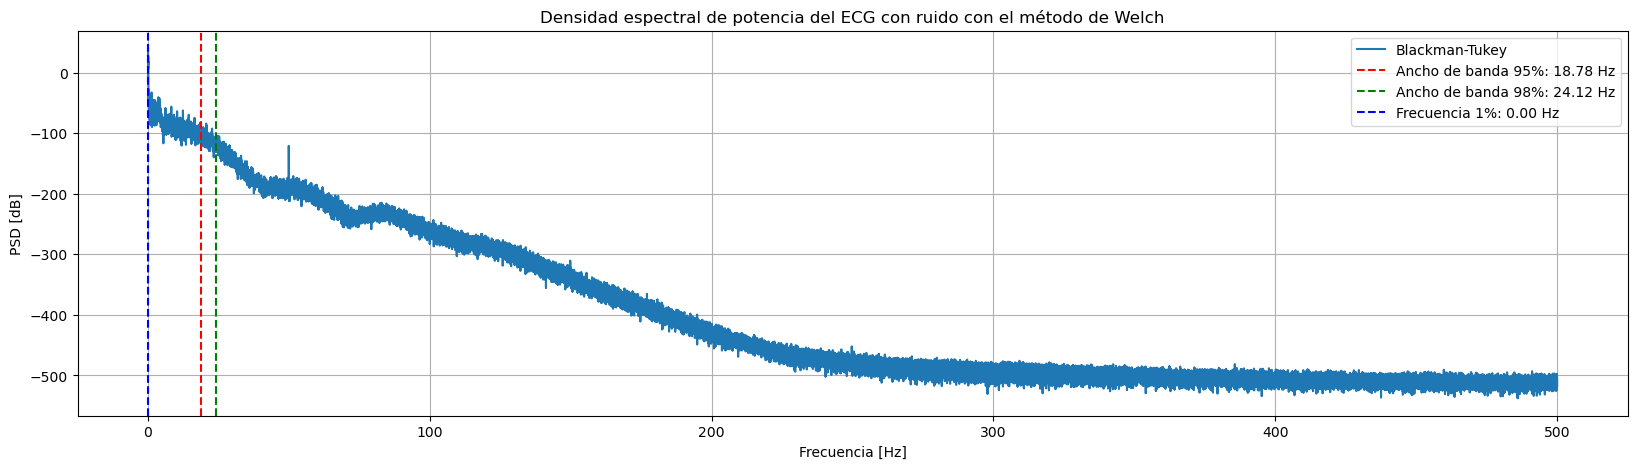

In [19]:
energia_total_ruido_ecg=np.sum(Pxxw_ecg_ruido) # La energia total del ECG espectro
energia_acumulada_ruido_ecg=np.cumsum(Pxxw_ecg_ruido) # La energia acumulada del ECG espectro
index_01_ruido_ecg=np.where(energia_acumulada_ruido_ecg>=0.001*energia_total_ruido_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_95_ruido_ecg=np.where(energia_acumulada_ruido_ecg>=0.95*energia_total_ruido_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
indx_98_ruido_ecg=np.where(energia_acumulada_ruido_ecg>=0.98*energia_total_ruido_ecg)[0][0] # El indice de la energia acumulada del ECG espectro
ancho_banda_95_ecg_ruido=fw_ecg_ruido[indx_95_ruido_ecg] # El ancho de banda del ECG espectro
ancho_banda_98_ecg_ruido=fw_ecg_ruido[indx_98_ruido_ecg] # El ancho de banda del ECG espectro

plt.figure(3,figsize=(20, 5))
plt.plot(fw_ecg_ruido,10*np.log(np.abs(Pxxw_ecg_ruido)**2), label='Blackman-Tukey')
plt.axvline(x=fw_ecg_ruido[indx_95_ruido_ecg], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_ruido:.2f} Hz')
plt.axvline(x=fw_ecg_ruido[indx_98_ruido_ecg], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_ruido:.2f} Hz')
plt.axvline(x=fw_ecg_ruido[index_01_ruido_ecg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ecg_ruido[index_01_ruido_ecg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG con ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

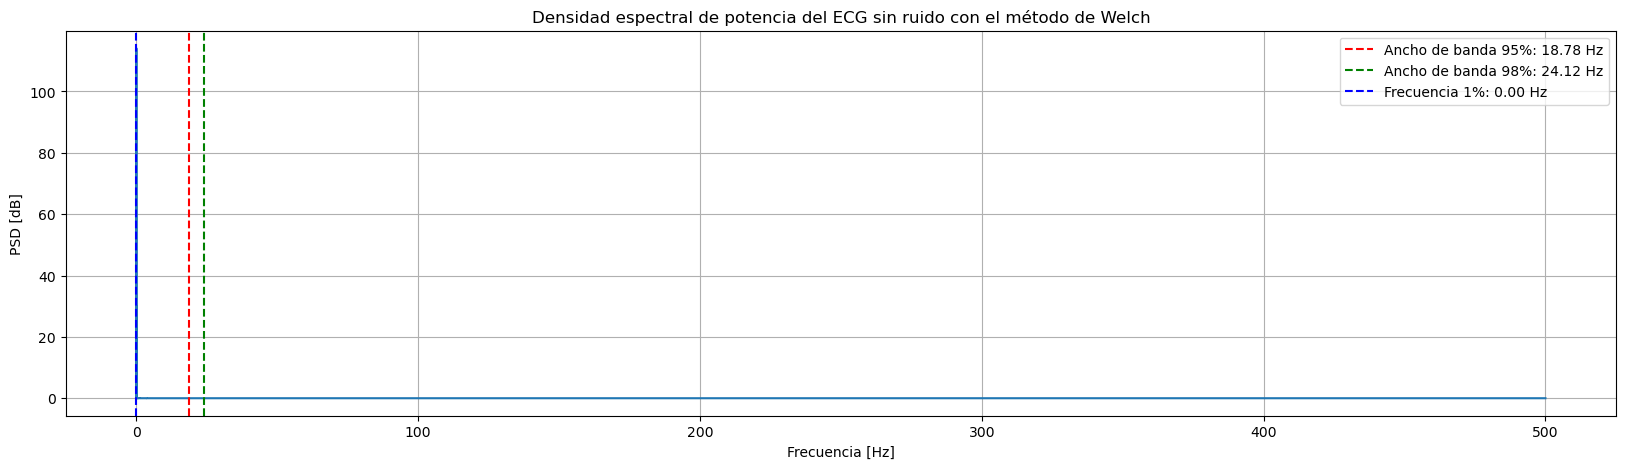

In [20]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_ecg_ruido,2*np.abs(Pxxw_ecg_ruido)**2)
plt.axvline(x=fw_ecg_ruido[indx_95_ruido_ecg], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_ecg_ruido:.2f} Hz')
plt.axvline(x=fw_ecg_ruido[indx_98_ruido_ecg], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_ecg_ruido:.2f} Hz')
plt.axvline(x=fw_ecg_ruido[index_01_ruido_ecg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ecg_ruido[index_01_ruido_ecg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del ECG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

# PPG

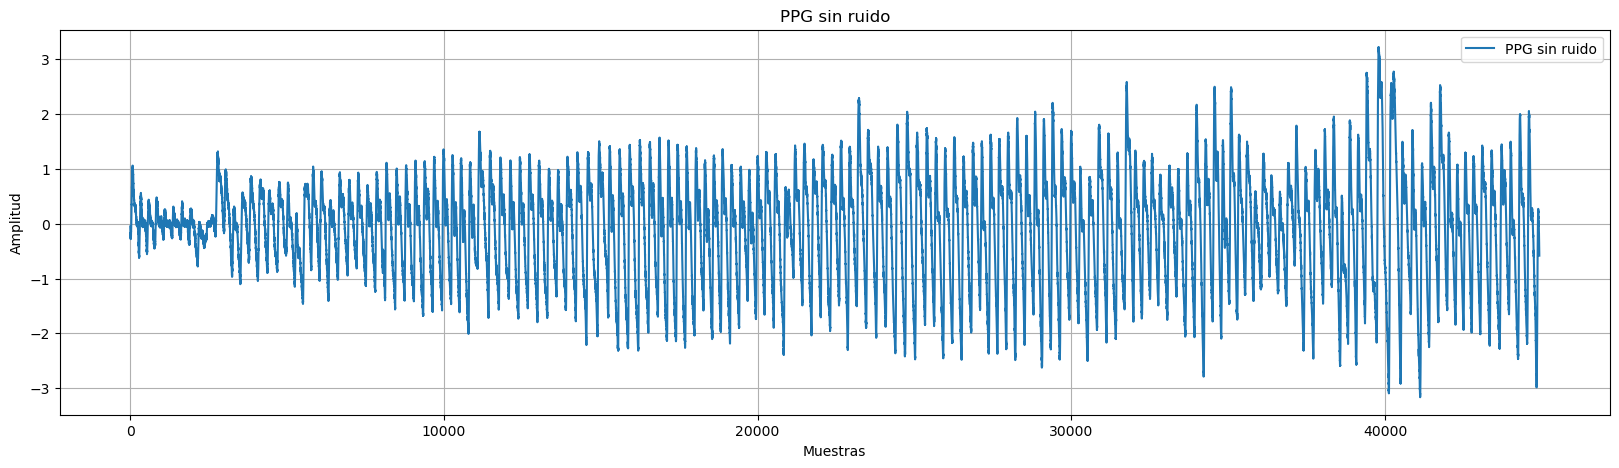

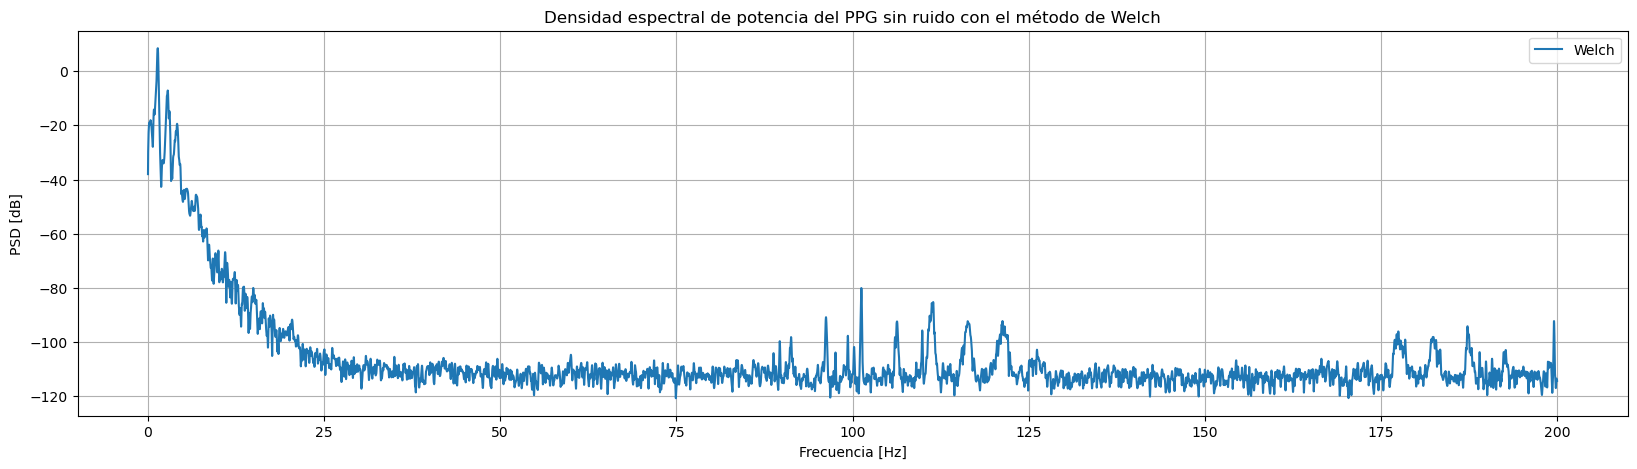

In [21]:
fs_ppg= 400 # Hz
ppg = np.load('ppg_sin_ruido.npy')
N = len(ppg) # Número de muestras
nor_ppg = ppg / np.std(ppg) # normalizamos el PPG
fw_ppg, Pxxw_ppg = signal.welch(nor_ppg, fs_ppg, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(1,figsize=(20, 5))
plt.plot(nor_ppg, label='PPG sin ruido')
plt.title('PPG sin ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_ppg,10*np.log10(np.abs(Pxxw_ppg)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()


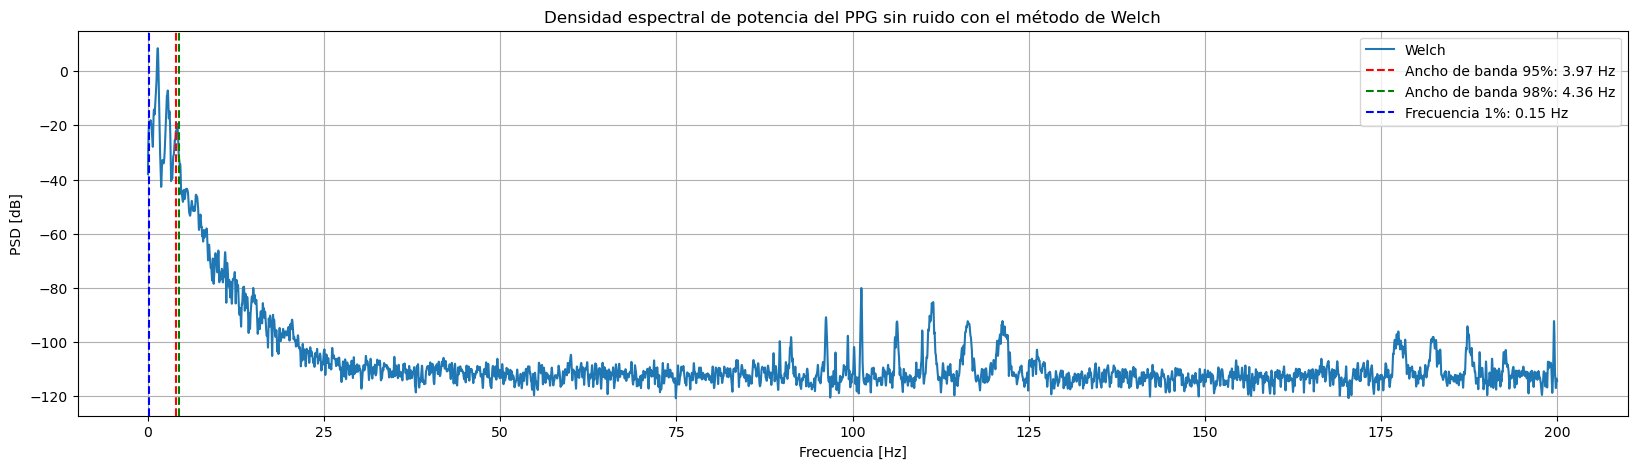

In [22]:
energia_total_w_ppg=np.sum(Pxxw_ppg) # La energia total del PPG espectro
energia_acumulada_w_ppg=np.cumsum(Pxxw_ppg) # La energia acumulada del PPG espectro
indx_95_w_ppg=np.where(energia_acumulada_w_ppg>=0.95*energia_total_w_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
indx_98_w_ppg=np.where(energia_acumulada_w_ppg>=0.98*energia_total_w_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
indx_1_w_ppg=np.where(energia_acumulada_w_ppg>=0.01*energia_total_w_ppg)[0][0] # El indice de la energia acumulada del PPG espectro
ancho_banda_95_w_ppg=fw_ppg[indx_95_w_ppg] # El ancho de banda del PPG espectro
ancho_banda_98_w_ppg=fw_ppg[indx_98_w_ppg] # El ancho de banda del PPG espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_ppg, 10*np.log10(np.abs(Pxxw_ppg)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_ppg, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_ppg:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_ppg, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_ppg:.2f} Hz')
plt.axvline(x=fw_ppg[indx_1_w_ppg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ppg[indx_1_w_ppg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

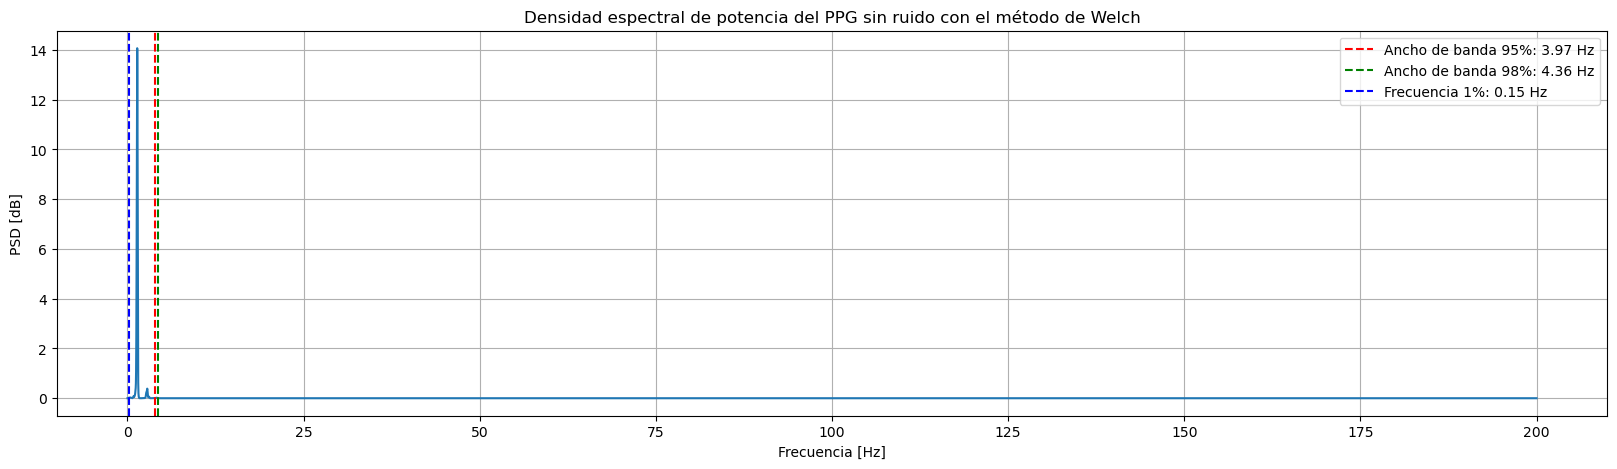

In [23]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_ppg,2*np.abs(Pxxw_ppg)**2)
plt.axvline(x=fw_ppg[indx_95_w_ppg], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_ppg:.2f} Hz')
plt.axvline(x=fw_ppg[indx_98_w_ppg], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_ppg:.2f} Hz')
plt.axvline(x=fw_ppg[indx_1_w_ppg], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_ppg[indx_1_w_ppg]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del PPG sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

Nuevamente se nota como la potencia se encuntra en el intervalo estimado, de esta manera se puede aceptar este ancho de banda calculado.

# Sonido

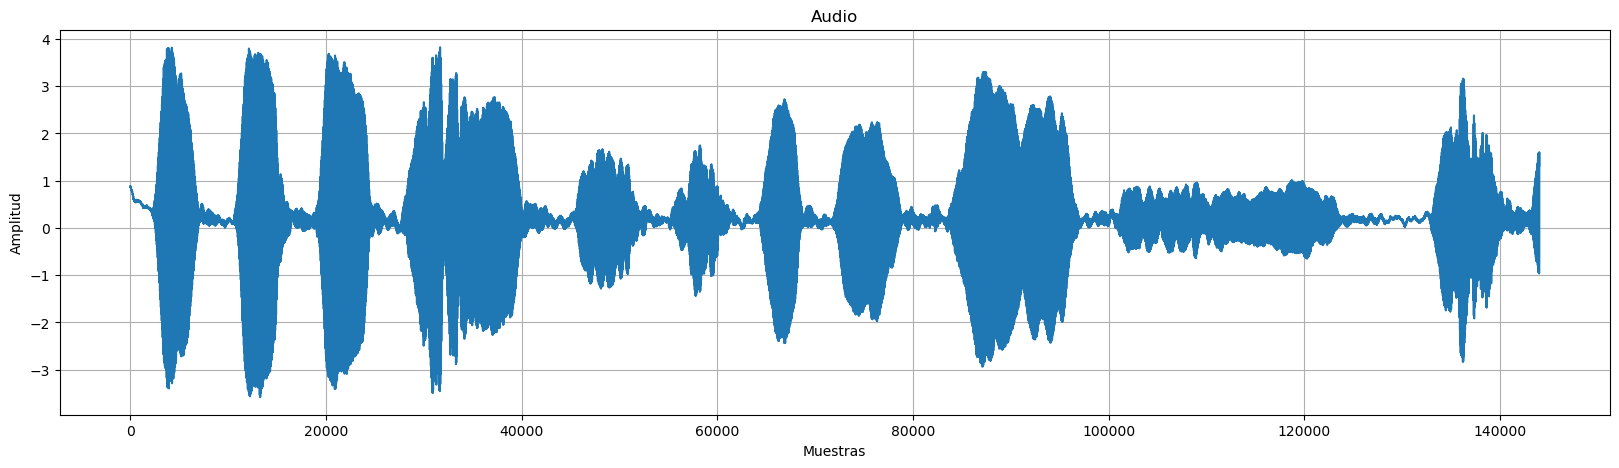

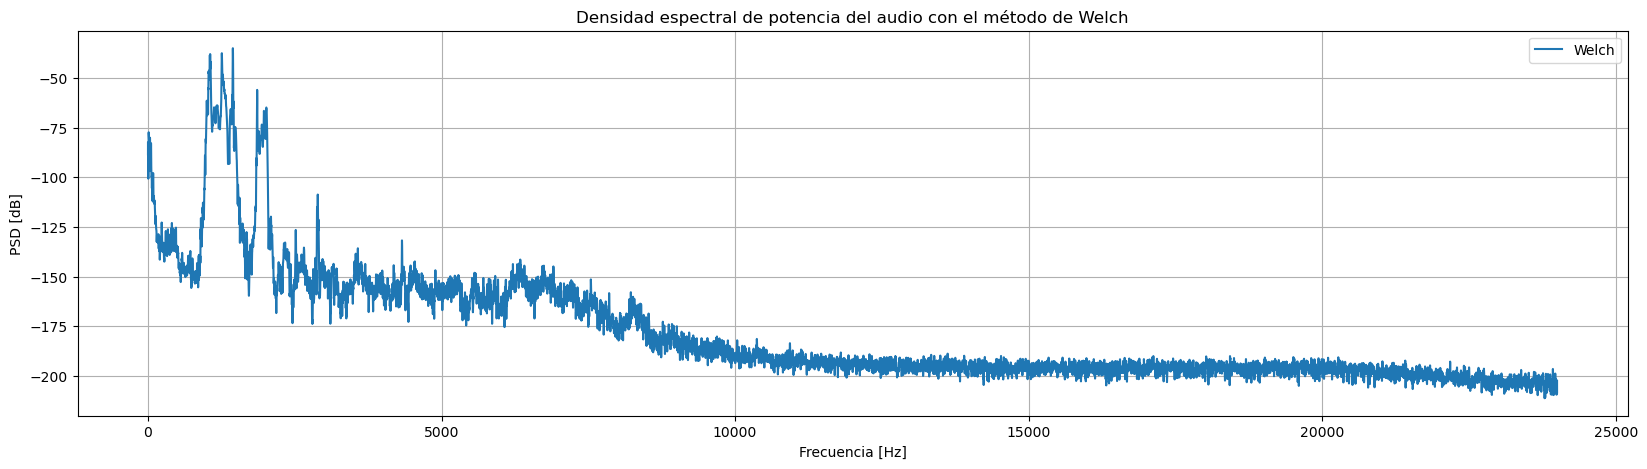

In [24]:
fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
N = len(wav_data) # Número de muestras
nor_audio = wav_data / np.std(wav_data) # normalizamos el audio
fw_audio, Pxxw_audio = signal.welch(nor_audio, fs_audio, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio)
plt.title('Audio')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio,10*np.log10(np.abs(Pxxw_audio)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()
## Arrancar el audio desde el espectro audible en Hz

Es esperable que para un sonido, la potencia se encuentre en donde el intervalo de la PSD alcanza su maximo. En ese sector se encontrar el ancho de banda de los audios usados. 

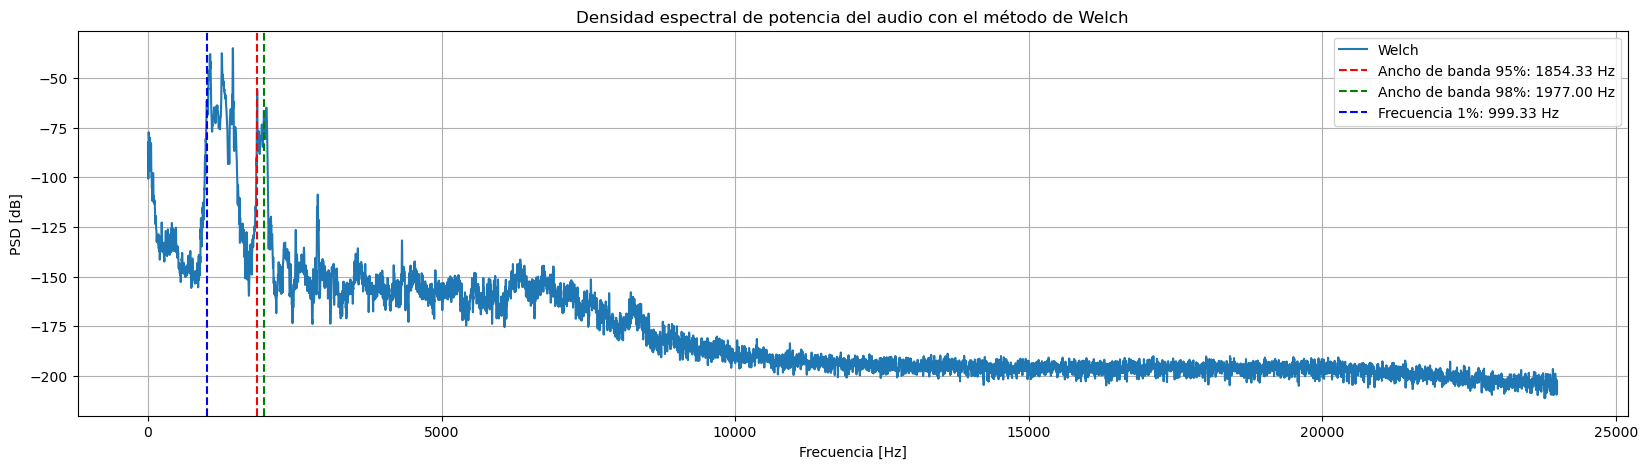

In [25]:
energia_total_w_audio=np.sum(Pxxw_audio) # La energia total del audio espectro
energia_acumulada_w_audio=np.cumsum(Pxxw_audio) # La energia acumulada del audio espectro
indx_95_w_audio=np.where(energia_acumulada_w_audio>=0.95*energia_total_w_audio)[0][0] # El indice de la energia acumulada del audio espectro
indx_98_w_audio=np.where(energia_acumulada_w_audio>=0.98*energia_total_w_audio)[0][0] # El indice de la energia acumulada del audio espectro
indx_1_w_audio=np.where(energia_acumulada_w_audio>=0.01*energia_total_w_audio)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio=fw_audio[indx_95_w_audio] # El ancho de banda del audio espectro
ancho_banda_98_w_audio=fw_audio[indx_98_w_audio] # El ancho de banda del audio espectroanda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio, 10*np.log10(np.abs(Pxxw_audio)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio:.2f} Hz')
plt.axvline(x=fw_audio[indx_1_w_audio], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio[indx_1_w_audio]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

# Observacion 
En la grafica se ve que para el 1% de la potencia concentrada, la densidad espectral de potencia indica el inicio del maximo, comenzando asi el ancho de banda hasta el bin donde empieza a decrecer hasta llegar aproximadamente -125dB dando fin al ancho de banda que se estima 

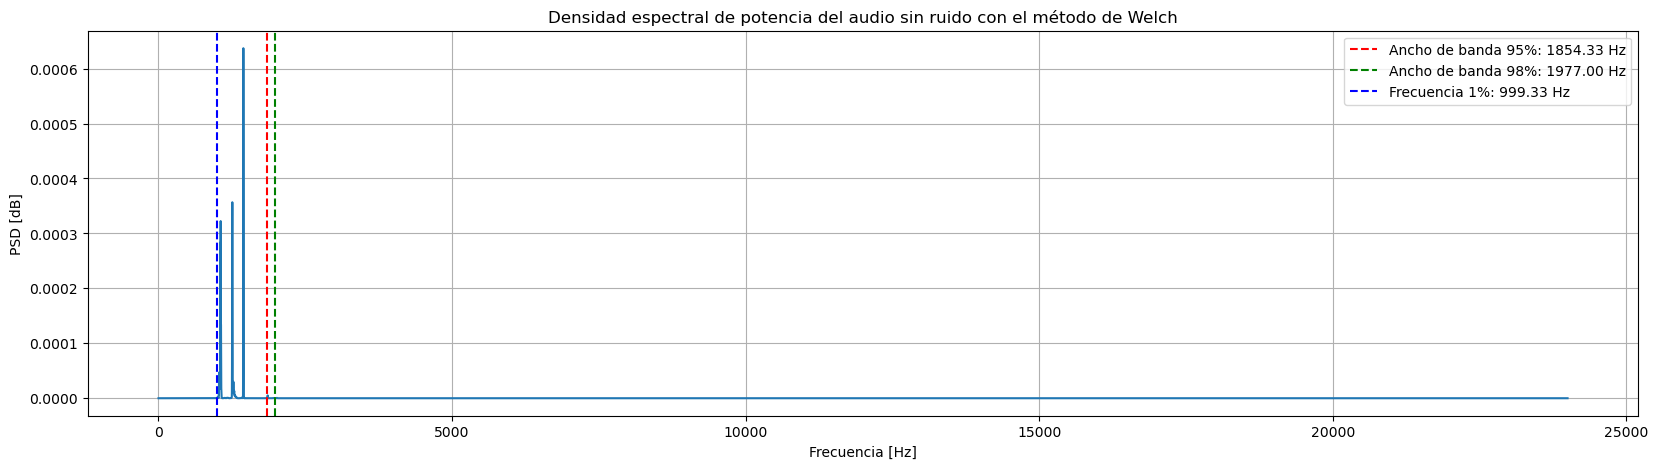

In [26]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio,2*np.abs(Pxxw_audio)**2)
plt.axvline(x=fw_audio[indx_95_w_audio], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio:.2f} Hz')
plt.axvline(x=fw_audio[indx_98_w_audio], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio:.2f} Hz')
plt.axvline(x=fw_audio[indx_1_w_audio], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio[indx_1_w_audio]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

Aca verifico que mi estimacion sea correcta y que los umbreales esten en el intervalo de concentracion de potencia

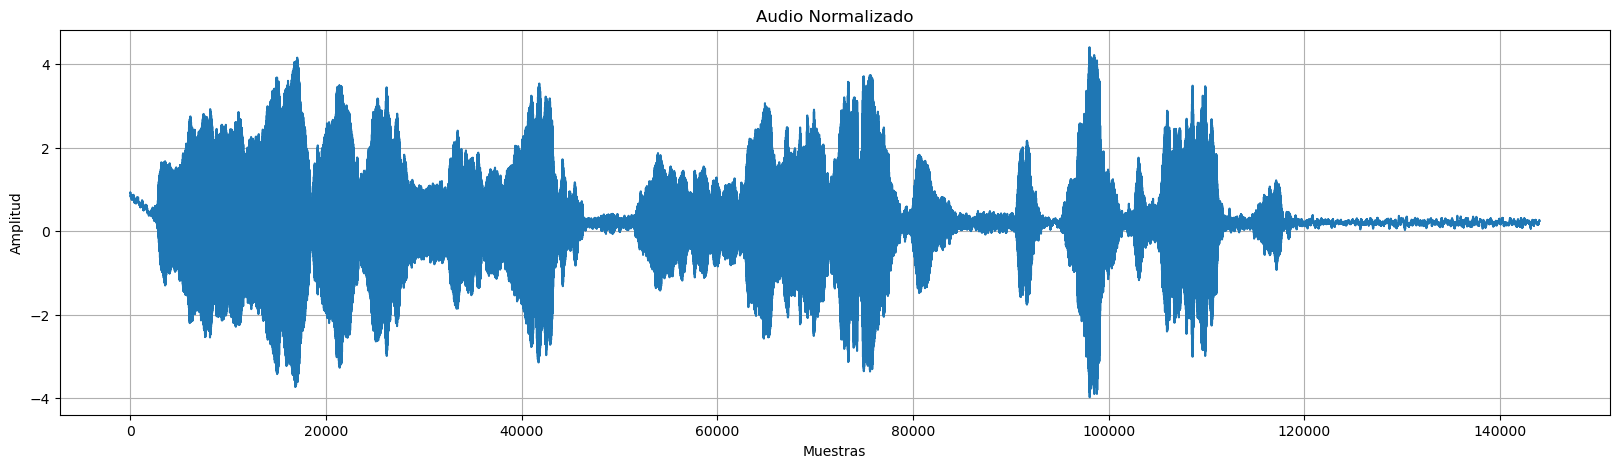

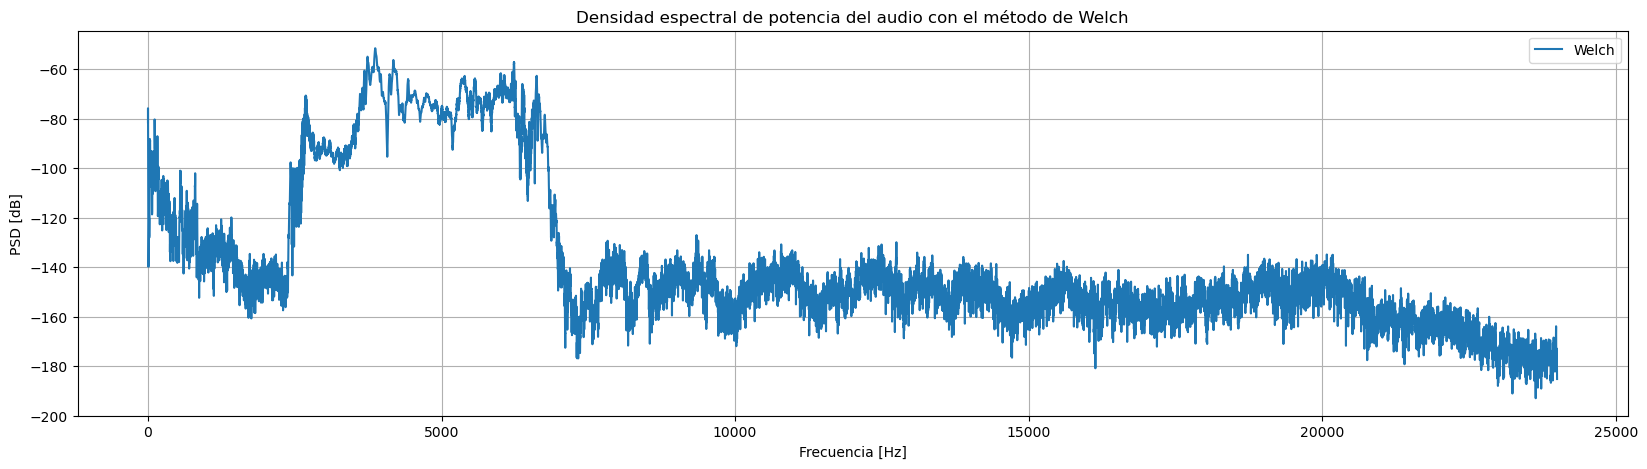

In [27]:
fs_audio_2, wav_data_2 = sio.wavfile.read('silbido.wav')
N = len(wav_data_2) # Número de muestras
nor_audio_2 = wav_data_2 / np.std(wav_data_2) # normalizamos el audio
fw_audio_2, Pxxw_audio_2 = signal.welch(nor_audio_2, fs_audio_2, nfft=N, window='blackman', nperseg=(N//4), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio_2)
plt.title('Audio Normalizado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio_2,10*np.log10(np.abs(Pxxw_audio_2)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()


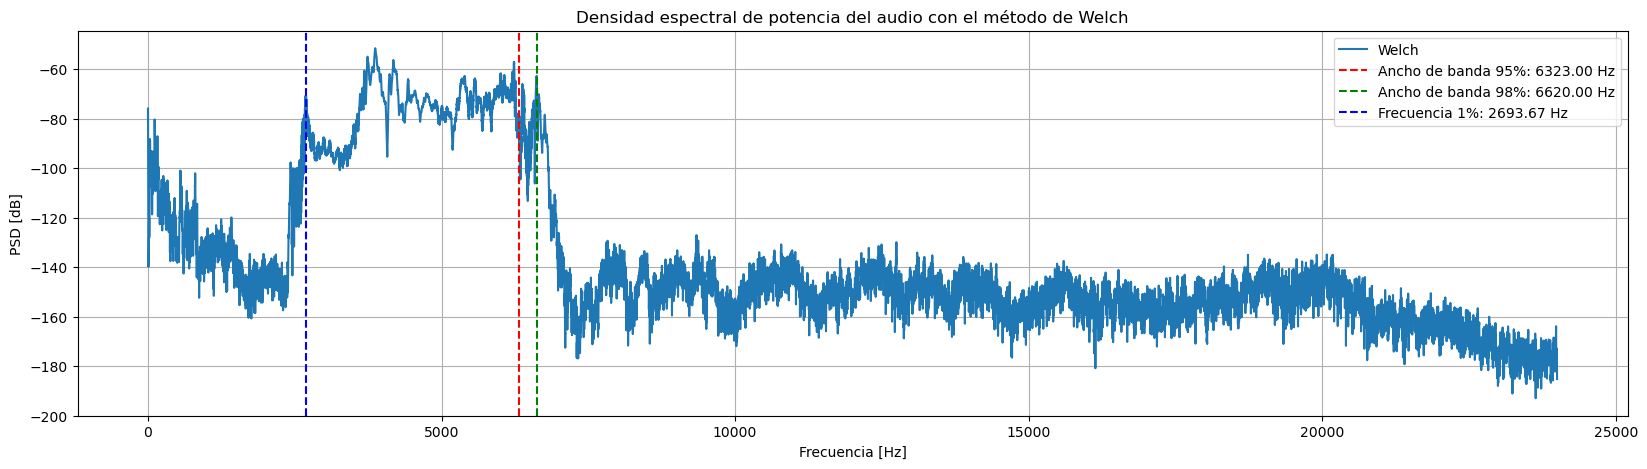

In [28]:
energia_total_w_audio_2=np.sum(Pxxw_audio_2) # La energia total del audio espectro
energia_acumulada_w_audio_2=np.cumsum(Pxxw_audio_2) # La energia acumulada del audio espectro
indx_95_audio2=np.where(energia_acumulada_w_audio_2>=0.95*energia_total_w_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
indx_98_audio2=np.where(energia_acumulada_w_audio_2>=0.98*energia_total_w_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
indx_1_audio2=np.where(energia_acumulada_w_audio_2>=0.01*energia_total_w_audio_2)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio_2=fw_audio_2[indx_95_audio2] # El ancho de banda del audio espectro
ancho_banda_98_w_audio_2=fw_audio_2[indx_98_audio2] # El ancho de banda del audio espectroanda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_2, 10*np.log10(np.abs(Pxxw_audio_2)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio_2, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_2:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio_2, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_2:.2f} Hz')
plt.axvline(x=fw_audio_2[indx_1_audio2], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio_2[indx_1_audio2]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

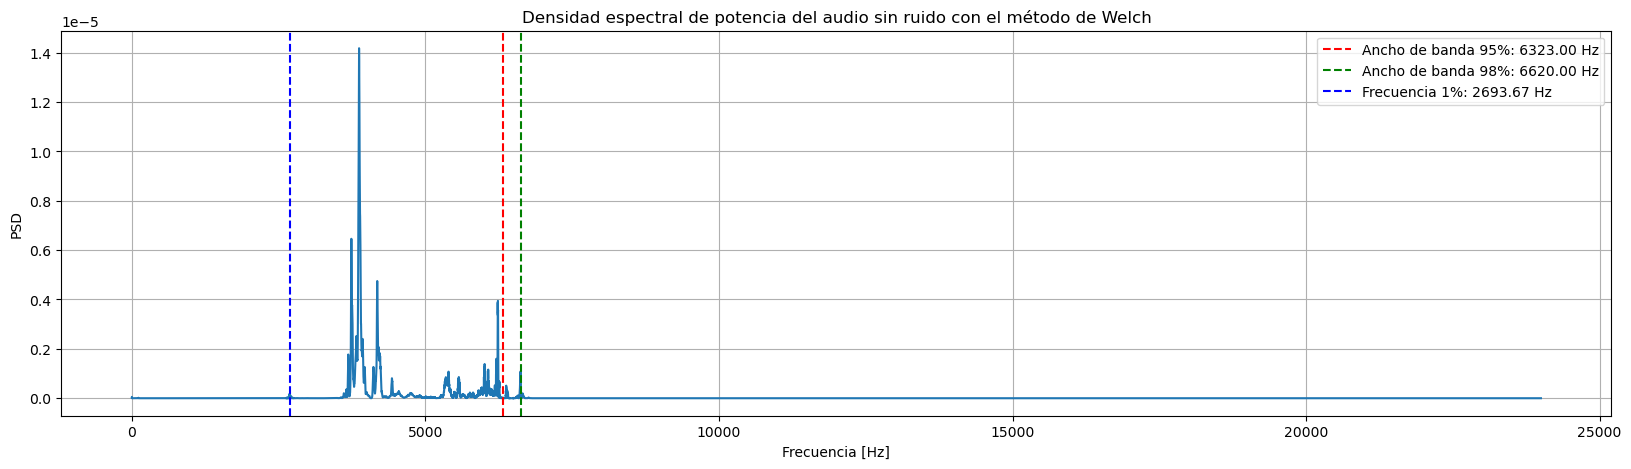

In [29]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_2,2*np.abs(Pxxw_audio_2)**2)
plt.axvline(x=fw_audio_2[indx_95_audio2], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_2:.2f} Hz')
plt.axvline(x=fw_audio_2[indx_98_audio2], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_2:.2f} Hz')
plt.axvline(x=fw_audio_2[indx_1_audio2], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio_2[indx_1_audio2]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.title('Densidad espectral de potencia del audio sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

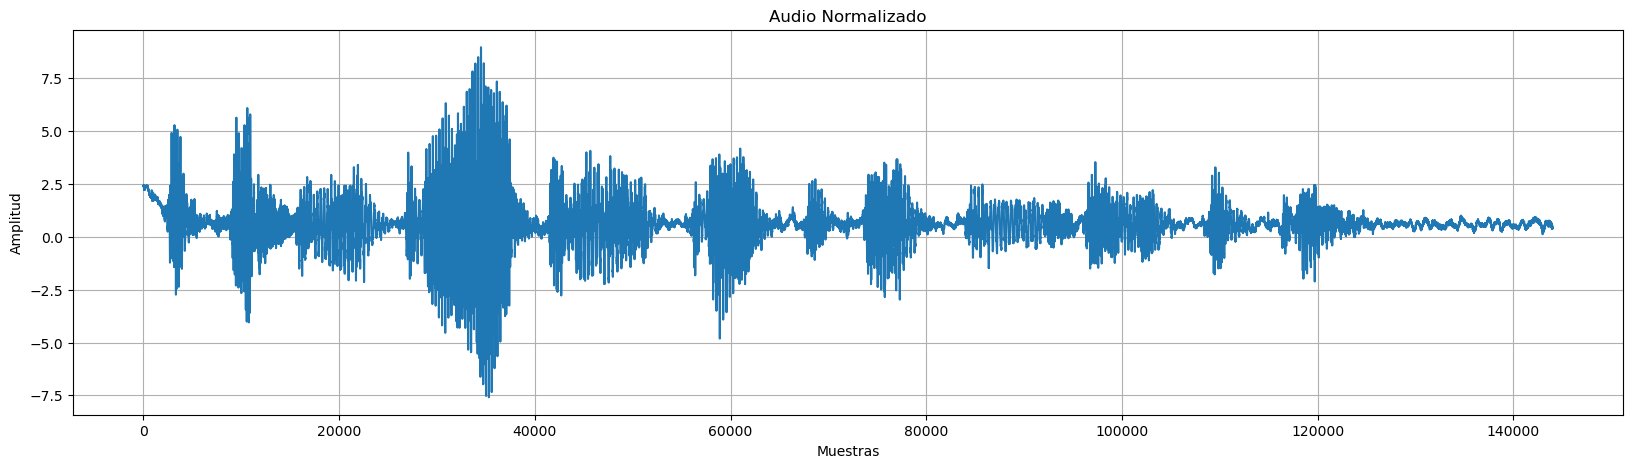

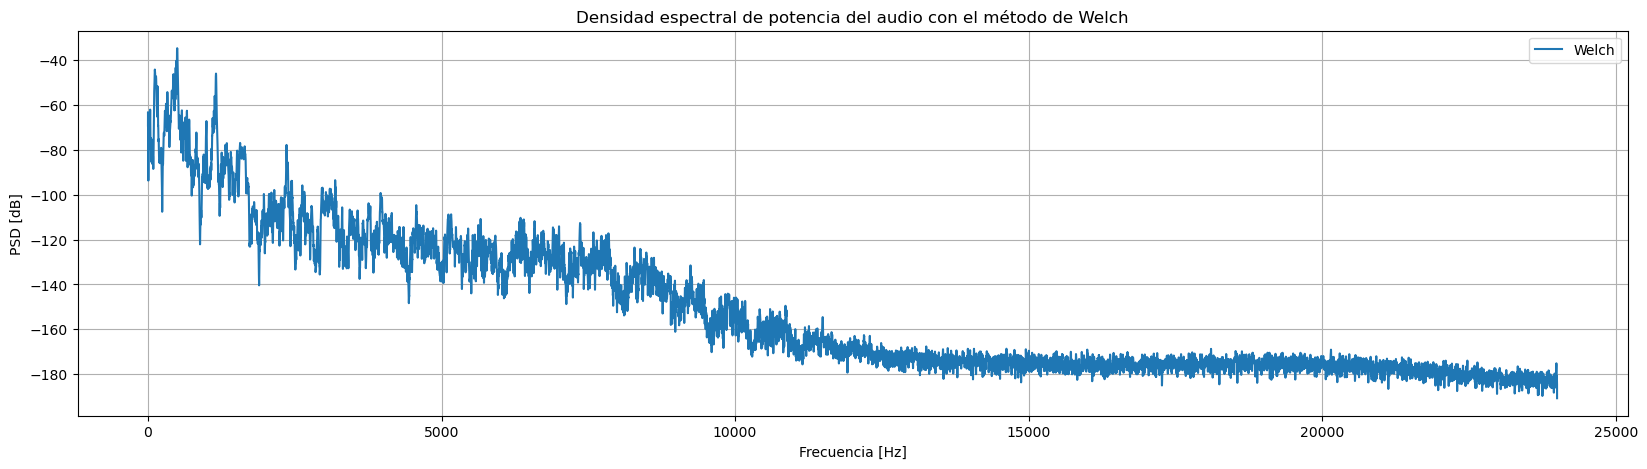

In [30]:
fs_audio_3, wav_data_3 = sio.wavfile.read('prueba psd.wav')
N = len(wav_data_3) # Número de muestras
nor_audio_3 = wav_data_3 / np.std(wav_data_3) # normalizamos el audio
fw_audio_3, Pxxw_audio_3 = signal.welch(nor_audio_3, fs_audio_3, nfft=N, window='blackman', nperseg=(N//8), axis=0) # uso el metodo de Welch para calcular la PSD

plt.figure(1,figsize=(20, 5))
plt.plot(nor_audio_3)
plt.title('Audio Normalizado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(2,figsize=(20, 5))
plt.plot(fw_audio_3,10*np.log10(np.abs(Pxxw_audio_3)**2), label='Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

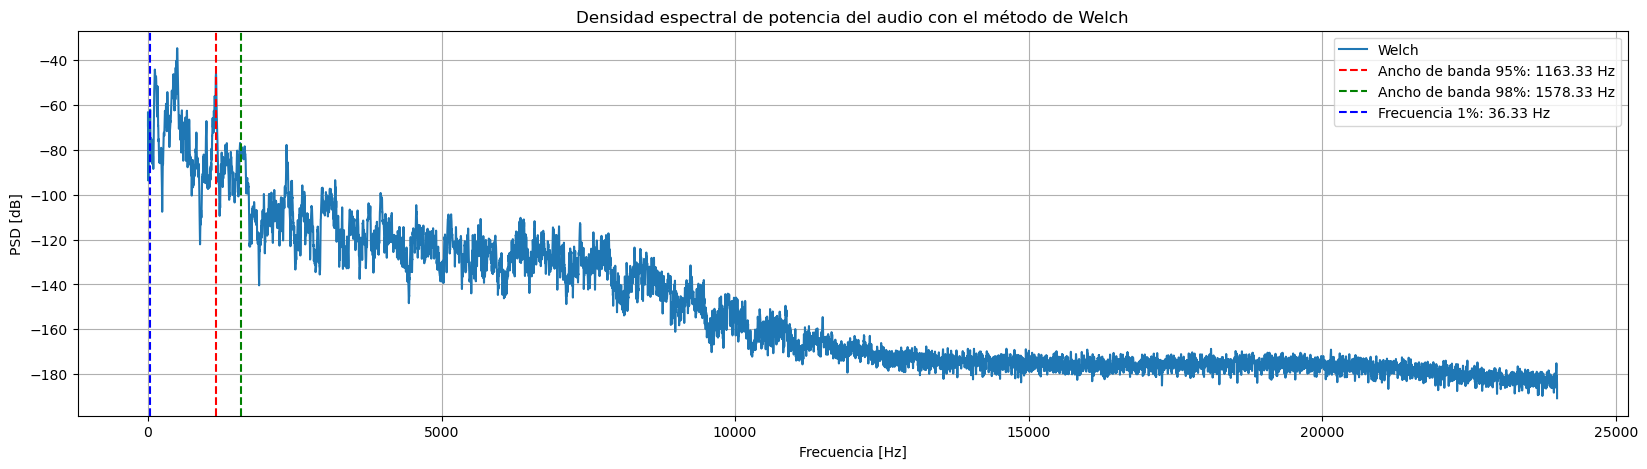

In [31]:
energia_total_w_audio_3=np.sum(Pxxw_audio_3) # La energia total del audio espectro
energia_acumulada_w_audio_3=np.cumsum(Pxxw_audio_3) # La energia acumulada del audio espectro
indx_95_audio3=np.where(energia_acumulada_w_audio_3>=0.95*energia_total_w_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
indx_98_audio3=np.where(energia_acumulada_w_audio_3>=0.98*energia_total_w_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
indx_1_audio3=np.where(energia_acumulada_w_audio_3>=0.01*energia_total_w_audio_3)[0][0] # El indice de la energia acumulada del audio espectro
ancho_banda_95_w_audio_3=fw_audio_3[indx_95_audio3] # El ancho de banda del audio espectro
ancho_banda_98_w_audio_3=fw_audio_3[indx_98_audio3] # El ancho de banda del audio espectro

plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_3, 10*np.log10(np.abs(Pxxw_audio_3)**2), label='Welch')
plt.axvline(x=ancho_banda_95_w_audio_3, color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_3:.2f} Hz')
plt.axvline(x=ancho_banda_98_w_audio_3, color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_3:.2f} Hz')
plt.axvline(x=fw_audio_3[indx_1_audio3], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio_3[indx_1_audio3]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Densidad espectral de potencia del audio con el método de Welch')
plt.grid()
plt.legend()
plt.show()

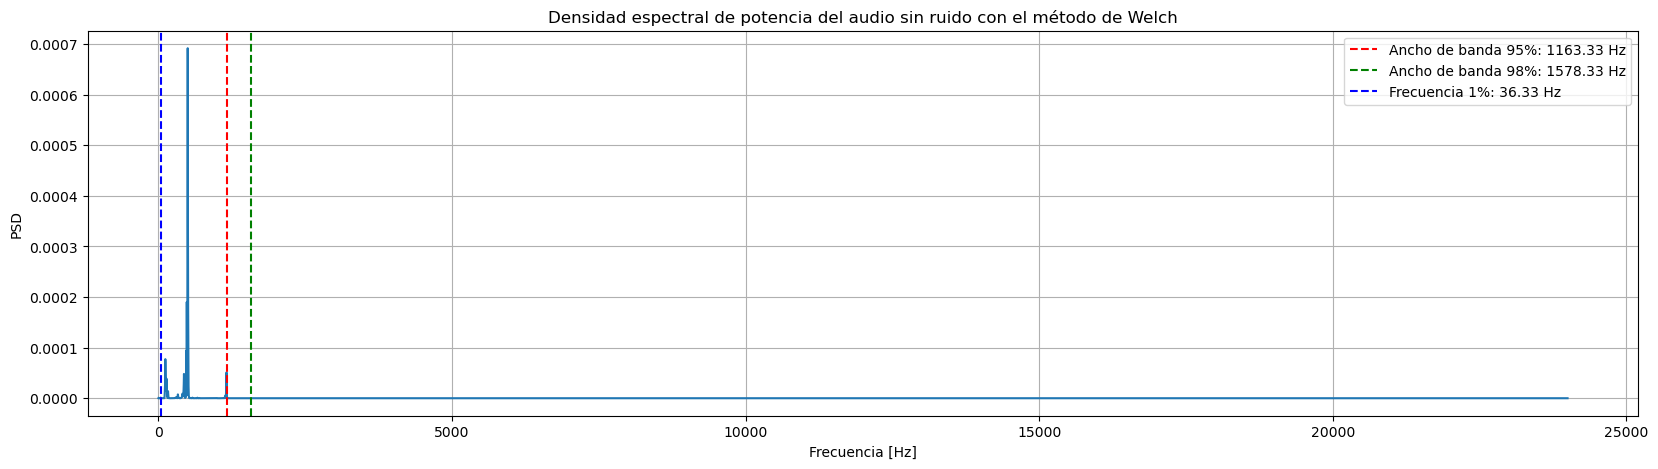

In [32]:
plt.figure(4,figsize=(20, 5))
plt.plot(fw_audio_3,2*np.abs(Pxxw_audio_3)**2)
plt.axvline(x=fw_audio_3[indx_95_audio3], color='r', linestyle='--', label=f'Ancho de banda 95%: {ancho_banda_95_w_audio_3:.2f} Hz')
plt.axvline(x=fw_audio_3[indx_98_audio3], color='g', linestyle='--', label=f'Ancho de banda 98%: {ancho_banda_98_w_audio_3:.2f} Hz')
plt.axvline(x=fw_audio_3[indx_1_audio3], color='b', linestyle='--', label=f'Frecuencia 1%: {fw_audio_3[indx_1_audio3]:.2f} Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.title('Densidad espectral de potencia del audio sin ruido con el método de Welch')
plt.grid()
plt.legend()
plt.show()

In [33]:
datos_indices = {
    'Señal': [
        'ECG',
        'ECG con ruido',
        'PPG',
        'Audio 1',
        'Audio 2',
        'Audio 3'
    ],
    'Frecuencia 1% (Hz)': [
        fw_ecg[index_01_w_ecg],
        fw_ecg_ruido[index_01_ruido_ecg],
        fw_ppg[indx_1_w_ppg],
        fw_audio[indx_1_w_audio],
        fw_audio_2[indx_1_audio2],
        fw_audio_3[indx_1_audio3]
    ],
    'Ancho de banda 95% (Hz)': [
        ancho_banda_95_ecg_w,
        fw_ecg_ruido[indx_95_ruido_ecg],
        ancho_banda_95_w_ppg,
        ancho_banda_95_w_audio,
        ancho_banda_95_w_audio_2,
        ancho_banda_95_w_audio_3
    ],
    'Ancho de banda 98% (Hz)': [
        ancho_banda_98_ecg_w,
        fw_ecg_ruido[indx_98_ruido_ecg],
        ancho_banda_98_w_ppg,
        ancho_banda_98_w_audio,
        ancho_banda_98_w_audio_2,
        ancho_banda_98_w_audio_3
    ]
}

tabla_indices = pd.DataFrame(datos_indices)
tabla_indices[['Frecuencia 1% (Hz)', 'Ancho de banda 95% (Hz)', 'Ancho de banda 98% (Hz)']] = tabla_indices[['Frecuencia 1% (Hz)', 'Ancho de banda 95% (Hz)', 'Ancho de banda 98% (Hz)']].round(2)
display(tabla_indices)

,Señal,Frecuencia 1% (Hz),Ancho de banda 95% (Hz),Ancho de banda 98% (Hz)
0,ECG,0.47,23.40,27.77
1,ECG con ruido,0.00,18.78,24.12
2,PPG,0.15,3.97,4.36
3,Audio 1,999.33,1854.33,1977.00
4,Audio 2,2693.67,6323.00,6620.00
5,Audio 3,36.33,1163.33,1578.33


# Analisis: 
Como metedo de estimacion para obtener el ancho de banda de distintos tipos de señales, yo creo que resulta bastante bueno para estimar el limite de cuando termina, debido a la forma en la cual se calculo y se obtuvo.Salvo las señales generadas por audio que no sufren alguna interferencia contaminante, a la hora de determianar el umbral inicial de las señales biologicas, este metodo por ahi no fue tan preciso como en el caso del PPG y el ECG con ruido, dejando asi la posibilidad de dejar pasar frecuencias bajas generadas por ruido o algun otro factor externo no deseado. 
Los valores obtenidos de la tabla corresponde a las energias de las señales usadas.